In [ ]:
# importing libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# dataframe display settings
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

# ignoring warnings
import warnings
warnings.filterwarnings("ignore")

# plotting style
sns.set_style('darkgrid')
plt.style.use('ggplot')

In [ ]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials


In [ ]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
#https://drive.google.com/file/d/1kYLjQTtCtLs1lZfWwq4ZvRmxwOpkro2B/view?usp=sharing

fileDownloaded = drive.CreateFile({'id':'1kYLjQTtCtLs1lZfWwq4ZvRmxwOpkro2B'})

In [ ]:
fileDownloaded.GetContentFile('Fraud_Detection dataset.csv')

In [ ]:
df = pd.read_csv('Fraud_Detection dataset.csv', index_col = False)
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [ ]:
# missing values summary
pd.DataFrame(zip(df.columns,
                 df.isna().any(),
                (df.isna().sum() / df.shape[0]) * 100),
             columns=['Column', 'Has Missing Values?', '% Missing Values'])\
    .sort_values('% Missing Values', ascending=False)

,Column,Has Missing Values?,% Missing Values
0,step,False,0.0
1,type,False,0.0
2,amount,False,0.0
3,nameOrig,False,0.0
4,oldbalanceOrg,False,0.0
5,newbalanceOrig,False,0.0
6,nameDest,False,0.0
7,oldbalanceDest,False,0.0
8,newbalanceDest,False,0.0
9,isFraud,False,0.0


In [ ]:
df['error_orig'] = (df["oldbalanceOrg"] - df["amount"] != df["newbalanceOrig"]).astype(int)
df['error_dest'] = (df["oldbalanceDest"] + df["amount"] != df["newbalanceDest"]).astype(int)

Checking the number of transactions in each class

In [ ]:
df.isFraud.value_counts()

0    6354407
1       8213
Name: isFraud, dtype: int64

Text(0.5, 1.0, 'No. of obervations in each transaction type')

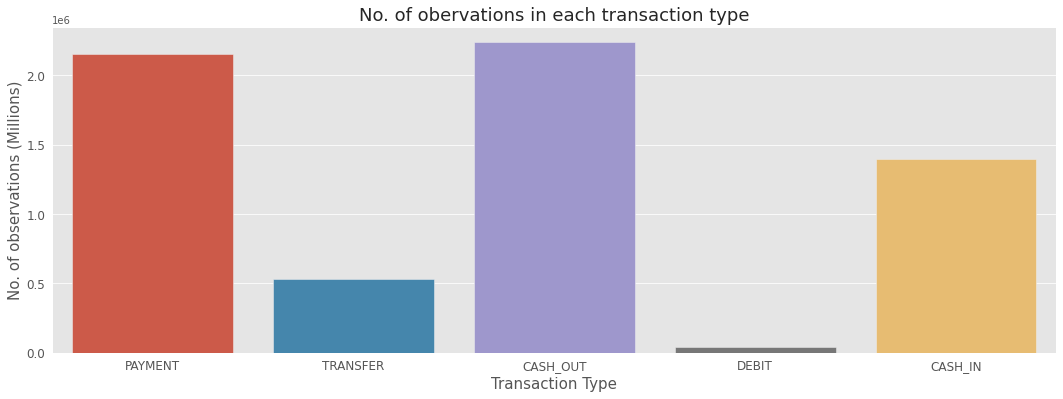

In [ ]:
# transaction type
plt.subplots(1,figsize=(18,6))
# countplot to visualize the no. of observations under each class
ax = sns.countplot(df['type'])
plt.xlabel('Transaction Type', fontsize=15)
plt.xticks(fontsize=12)
plt.ylabel('No. of observations (Millions)', fontsize=15)
plt.yticks(fontsize=12)
plt.title('No. of obervations in each transaction type', fontsize=18)


In [ ]:
# least transaction amount
print("Least amount transacted:", df['amount'].min());print()

# highest transaction amount
print("Highest amount transacted:", df['amount'].max()); print()

# highest transaction amount for each transaction type
print("Highest amount transacted in each transaction type:")

df.groupby('type')['amount'].max()

Least amount transacted: 0.0

Highest amount transacted: 92445516.64

Highest amount transacted in each transaction type:


type
CASH_IN      1915267.90
CASH_OUT    10000000.00
DEBIT         569077.51
PAYMENT       238637.98
TRANSFER    92445516.64
Name: amount, dtype: float64

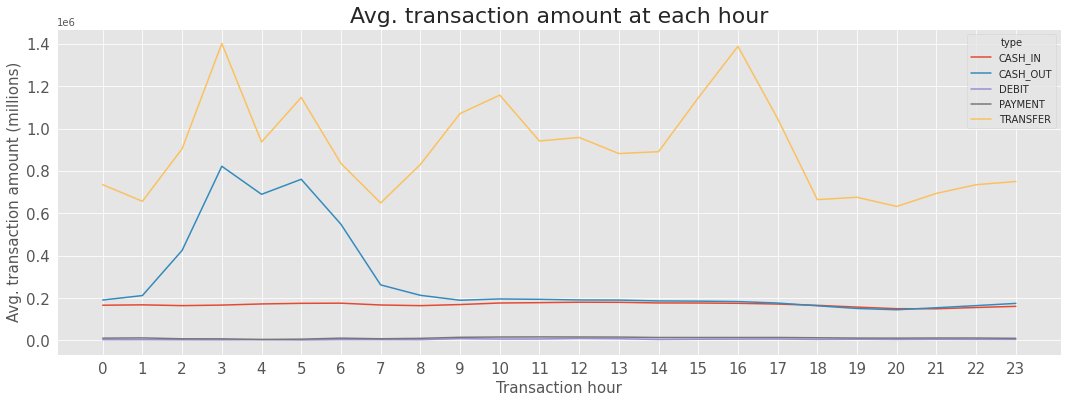

In [ ]:
# avg. transaction amount at each hour for each transaction type
plt.figure(figsize=(18,6))
sns.lineplot(data=df.groupby(['transactionHour','type']).agg({'amount' : 'mean'}).round(2).reset_index(),
             x='transactionHour',
             y='amount',
             hue='type')
plt.xlabel('Transaction hour', fontsize=15)
plt.xticks(range(24), range(24),fontsize=15, rotation=0)
plt.ylabel('Avg. transaction amount (millions)', fontsize=15)
plt.yticks(fontsize=15)
plt.title('Avg. transaction amount at each hour', fontsize=22)
plt.show()

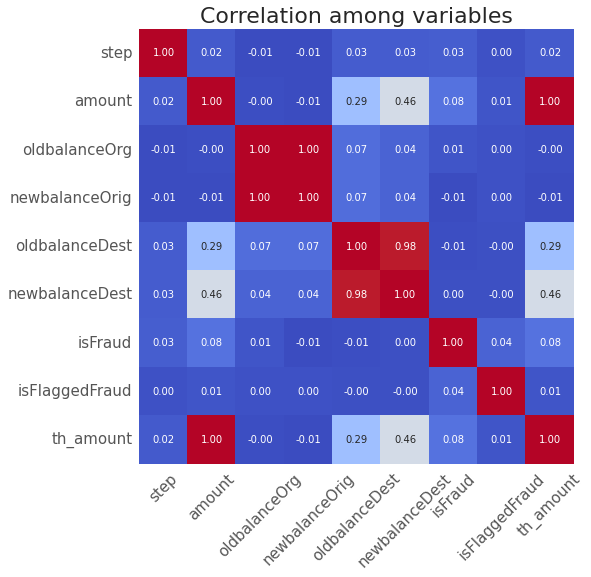

In [ ]:
# heat map of correlation among variables
plt.figure(figsize=(8,8))
sns.heatmap(df.corr(),
            fmt='.2f', annot=True, square=True, cmap='coolwarm', cbar=False)
plt.xticks(fontsize=15,  rotation=45)
plt.yticks(fontsize=15)
plt.title('Correlation among variables', fontsize=22)
plt.show()

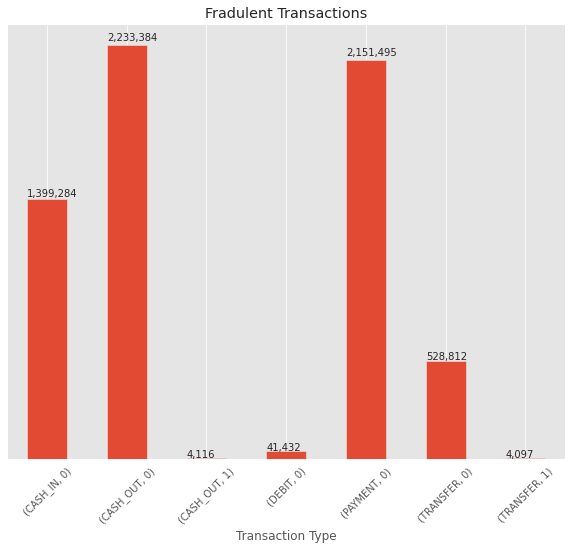

In [ ]:
plt.figure(figsize=(10,8))
ax = df.groupby(['type','isFraud']).size().plot(kind='bar')

for p in ax.patches:
    ax.annotate(str(format(int(p.get_height()), ',d')), (p.get_x(), p.get_height()*1.01))
plt.title("Fradulent Transactions")
plt.xlabel("Transaction Type")
plt.yticks([])
#plt.xticks([' Valid CashOut','Fraud CashOut','Valid Transfer','Fraud Transfer'])
plt.xticks(rotation=45)
plt.show()


Transactions with amount less than zero

In [ ]:
len(df[df.amount<=0])

16

Transaction type that is associated with amount <=0

In [ ]:
df[df.amount<=0]['type'].value_counts().index[0]

'CASH_OUT'

Are these transactions <= 0 mapped as fraud?

In [ ]:
df[df.amount<=0]['isFraud'].value_counts()[1] == len(df[df.amount<=0])

True

Now let us analyze the transactions that were flagged as Fraud

In [ ]:
df_ff = df[df.isFlaggedFraud==1]

How many flagged transactions are there?

In [ ]:
df_ff.shape

(16, 13)

What type of transactions were flagged?

In [ ]:
df_ff['type'].value_counts().index[0]

'TRANSFER'

All of them are fraud?

In [ ]:
df_ff['isFraud'].value_counts()[1] == len(df_ff)

True

Minimum and maximum amounts transferred in these transactions

In [ ]:
print("Minimum Transaction",df_ff.amount.min())
print("Maximum Transaction",df_ff.amount.max())

Minimum Transaction 353874.22
Maximum Transaction 10000000.0


Now we can focus on the transactions that are either CASH_OUT or Transaction

In [ ]:
df = df.loc[(df['type'].isin(['TRANSFER', 'CASH_OUT']))]
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,error_orig,error_dest
2,1,TRANSFER,181.00,C1305486145,181.0,0.0,C553264065,0.0,0.00,1,0,0,1
3,1,CASH_OUT,181.00,C840083671,181.0,0.0,C38997010,21182.0,0.00,1,0,0,1
15,1,CASH_OUT,229133.94,C905080434,15325.0,0.0,C476402209,5083.0,51513.44,0,0,1,1
19,1,TRANSFER,215310.30,C1670993182,705.0,0.0,C1100439041,22425.0,0.00,0,0,1,1
24,1,TRANSFER,311685.89,C1984094095,10835.0,0.0,C932583850,6267.0,2719172.89,0,0,1,1


We can remove the features that are no longer needed

In [ ]:
df.drop(['step','type','nameOrig','nameDest','error_orig','error_dest','isFlaggedFraud'],axis=1,inplace=True)
df.head()

,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud
2,181.00,181.0,0.0,0.0,0.00,1
3,181.00,181.0,0.0,21182.0,0.00,1
15,229133.94,15325.0,0.0,5083.0,51513.44,0
19,215310.30,705.0,0.0,22425.0,0.00,0
24,311685.89,10835.0,0.0,6267.0,2719172.89,0


Let us standardize the values to be between 0 and 1

In [ ]:
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()

df.amount         = ss.fit_transform(df[['amount']])
df.oldbalanceOrg  = ss.fit_transform(df[['oldbalanceOrg']])
df.oldbalanceDest = ss.fit_transform(df[['oldbalanceDest']])
df.newbalanceOrig = ss.fit_transform(df[['newbalanceOrig']])
df.newbalanceDest = ss.fit_transform(df[['newbalanceDest']])


In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:

X = df.drop(["isFraud"],axis=1)
y = df.isFraud
X_train, X_test, y_train, y_test = train_test_split(X, y,stratify=y)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((2077806, 5), (692603, 5), (2077806,), (692603,))

Applying logistic regression for classification

In [ ]:
from sklearn.linear_model import LogisticRegression


In [ ]:
lr = LogisticRegression(solver='newton-cg')
lr.fit(X_train, y_train)

lr_pred = lr.predict(X_test)

F1 Score(Cheking for F1 score instead of accuracy since the dataset is highly imbalanced)

In [ ]:
from sklearn.metrics import f1_score


In [ ]:
f1_score(y_test, lr_pred)

0.6094364351245085

Let us try to handle the imbalanced dataset by upsampling the minority class

In [ ]:
n = df.isFraud.value_counts()[0]

# Separate majority and minority classes
df_majority = df[df.isFraud==0]
df_minority = df[df.isFraud==1]

In [ ]:
from sklearn.utils import resample


In [ ]:
# Upsample the minority class
df_minority_upsampled = resample(df_minority, 
                                 replace=True,     # sample with replacement
                                 n_samples=n,    # to match majority class
                                 random_state=123) # reproducible results
 
# Combining majority class with upsampled minority class
df_upsampled = pd.concat([df_majority, df_minority_upsampled])
 
print("The new class count are :")
df_upsampled.isFraud.value_counts()

The new class count are :


0    2762196
1    2762196
Name: isFraud, dtype: int64

Now working on logistic regression with upsampled data

In [ ]:
X = df_upsampled.drop(["isFraud"],axis = 1)
y = df_upsampled.isFraud
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [ ]:
lr = LogisticRegression(solver='newton-cg')
lr.fit(X_train, y_train)

LogisticRegression(solver='newton-cg')

In [ ]:
up_scale_pred = lr.predict(X_test) #predicting the upscaled data

Let us see how the F1 score turned out for the upscaled dataset

In [ ]:
f1_score(y_test, up_scale_pred)

0.8971911195900981

Since the data is no longer imbalanced, let us check how the accuracy is

In [ ]:
from sklearn.metrics import accuracy_score


In [ ]:
accuracy_score(y_test, up_scale_pred)

0.9004227071503977

Let us see the classification report.

Since False Negatives are more dangerous than the false positives, a higher recall score is important for our model

In [ ]:
from sklearn.metrics import classification_report


In [ ]:
print(classification_report(y_test,up_scale_pred))

              precision    recall  f1-score   support

           0       0.88      0.93      0.90    690439
           1       0.93      0.87      0.90    690659

    accuracy                           0.90   1381098
   macro avg       0.90      0.90      0.90   1381098
weighted avg       0.90      0.90      0.90   1381098



Now let us work with the downsampled data

In [ ]:
n = df.isFraud.value_counts()[1]
# Separate majority and minority classes

df_majority = df[df.isFraud==0]
df_minority = df[df.isFraud==1]
# Downsample majority class
df_majority_downsampled = resample(df_majority, 
                                 replace=False,    # sample without replacement
                                 n_samples=n,     # to match minority class
                                 random_state=123) # reproducible results
 
# Combine minority class with downsampled majority class
df_downsampled = pd.concat([df_majority_downsampled, df_minority])
 
print("The new class count are:")
print(df_downsampled.isFraud.value_counts())

The new class count are:
0    8213
1    8213
Name: isFraud, dtype: int64


In [ ]:
# Assign the features and target variables
y = df_downsampled.isFraud
X = df_downsampled.drop(['isFraud'], axis=1)

Let us apply the Logistic regression on downsampled data

In [ ]:
X = df_downsampled.drop(["isFraud"],axis = 1)
y = df_downsampled.isFraud
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [ ]:
lr = LogisticRegression(solver='newton-cg')
lr.fit(X_train, y_train)

LogisticRegression(solver='newton-cg')

In [ ]:
down_scale_pred = lr.predict(X_test) #predicting the upscaled data

F1 score and accuracy

In [ ]:
print("F1 Score:",f1_score(y_test, down_scale_pred))
print("Accuracy Score:",accuracy_score(y_test, down_scale_pred))

F1 Score: 0.8918425853531404
Accuracy Score: 0.8989530070611151


Let us work on the data with Random forests and Decision Trees 

Does decision trees work better with the downsampled data? Let us take a look

In [ ]:
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier(criterion = 'entropy', random_state = 42)
dt.fit(X_train, y_train)
dt_pred_train = dt.predict(X_train)

In [ ]:
# Evaluating on Test set
dt_pred_test = dt.predict(X_test)
print('Testing Set Evaluation F1-Score=>',f1_score(y_test,dt_pred_test))

Testing Set Evaluation F1-Score=> 0.9874812218327491


Let us see how random forest perform on downsampled data

In [ ]:
# Building  Random Forest Classifier
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(criterion = 'entropy', random_state = 42)
rfc.fit(X_train, y_train)

# Evaluating on Test set
rfc_pred_test = rfc.predict(X_test)
print('Testing Set Evaluation F1-Score=>',f1_score(y_test,rfc_pred_test))

Testing Set Evaluation F1-Score=> 0.9865403788634097


Let us work with Decision Trees with upsampled data

In [ ]:
X = df_upsampled.drop(["isFraud"],axis = 1)
y = df_upsampled.isFraud
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [ ]:
# Building Decision Tree
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier(criterion = 'entropy', random_state = 42)
dt.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', random_state=42)

In [ ]:
# Evaluating on Test set
dt_pred_test = dt.predict(X_test)
print('Testing Set Evaluation F1-Score=>',f1_score(y_test,dt_pred_test))

Testing Set Evaluation F1-Score=> 0.9998183924329699


Let us implements random forests with upsampled data

In [ ]:
rfc = RandomForestClassifier(criterion = 'entropy', random_state = 42)
rfc.fit(X_train, y_train)
# Evaluating on Test set
rfc_pred_test = rfc.predict(X_test)
print('Testing Set Evaluation F1-Score=>',f1_score(y_test,rfc_pred_test))

Testing Set Evaluation F1-Score=> 0.999829967042548


Though Random forest performs better than decision trees, on a large dataset, random forests takes a lot of time to run. Here in our case decision trees have projected a better F1 score and we can consider using it without implementing random forests.

K nearest neighbors:
it uses ‘feature similarity’ to predict the values of new datapoints

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
knn_ = KNeighborsClassifier(n_neighbors = 5, metric = 'minkowski', p = 2)
knn_.fit(X_train, y_train)

KNeighborsClassifier()

In [ ]:
knn_y_pred = knn_.predict(X_test)
print('Testing Set Evaluation F1-Score=>',f1_score(y_test,knn_y_pred))

Testing Set Evaluation F1-Score=> 0.999043503596441


SVM: support vector machine algorithm finds a hyperplane in an N-dimensional space that distinctly classifies the data points.
Applying SVM on downsampled data because SVM taking a longer time of large dataset

In [ ]:
X = df_downsampled.drop(["isFraud"],axis = 1)
y = df_downsampled.isFraud
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [ ]:
from sklearn.svm import SVC
svm = SVC(kernel='linear')
svm.fit(X_train,y_train)
svm_y_pred = svm.predict(X_test)
print('Testing Set Evaluation F1-Score=>',f1_score(y_test,svm_y_pred))


Testing Set Evaluation F1-Score=> 0.884919622352641
